In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func
from sqlalchemy.ext.declarative import declarative_base


In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

In [9]:
#checking columns on Measurement table
Measurement.metadata.tables

FacadeDict({'measurement': Table('measurement', MetaData(), Column('id', INTEGER(), table=<measurement>, primary_key=True, nullable=False), Column('station', TEXT(), table=<measurement>), Column('date', TEXT(), table=<measurement>), Column('prcp', FLOAT(), table=<measurement>), Column('tobs', FLOAT(), table=<measurement>), schema=None), 'station': Table('station', MetaData(), Column('id', INTEGER(), table=<station>, primary_key=True, nullable=False), Column('station', TEXT(), table=<station>), Column('name', TEXT(), table=<station>), Column('latitude', FLOAT(), table=<station>), Column('longitude', FLOAT(), table=<station>), Column('elevation', FLOAT(), table=<station>), schema=None)})

In [10]:
#checking columns on Station table
Station.metadata.tables

FacadeDict({'measurement': Table('measurement', MetaData(), Column('id', INTEGER(), table=<measurement>, primary_key=True, nullable=False), Column('station', TEXT(), table=<measurement>), Column('date', TEXT(), table=<measurement>), Column('prcp', FLOAT(), table=<measurement>), Column('tobs', FLOAT(), table=<measurement>), schema=None), 'station': Table('station', MetaData(), Column('id', INTEGER(), table=<station>, primary_key=True, nullable=False), Column('station', TEXT(), table=<station>), Column('name', TEXT(), table=<station>), Column('latitude', FLOAT(), table=<station>), Column('longitude', FLOAT(), table=<station>), Column('elevation', FLOAT(), table=<station>), schema=None)})

In [11]:
#getting table names using 'inspect'
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [12]:
#getting a list of column names and types
columns = inspector.get_columns("measurement")
for column in columns:
    print (column['name'], column['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Precipitation Analysis

In [14]:
import datetime

In [15]:
# Find the most recent date in the data set.
#results = session.query(measurement).filter(measurement.date).max
#print(results)
#results = session.query(Measurement).order_by(Measurement.date.desc()).limit(1)
#results = session.query(measurement.date).all()
#for record in results
        #print(record.date)
#first_row = session.query(Measurement).first()
#first_row.date
#print(results)
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(recent_date)

('2017-08-23',)


In [38]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database.
# Calculate the date one year from the last date in data set.

latest_date = dt.datetime.strptime(recent_date[0], '%Y-%m-%d')
start_date = latest_date - dt.timedelta(days=365)
print(start_date)

# Perform a query to retrieve the data and precipitation scores
sel = [Measurement.date, func.sum(Measurement.prcp)]

precipitation_scores = session.query(*sel).\
        filter(func.strftime(Measurement.date) >= start_date).\
        group_by(Measurement.date).\
        order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_scores = pd.DataFrame(precipitation, columns=['Measurement_date', 'Precipitation_amount'])

# Sort the dataframe by date
precipitation_scores.sort_values(by='Measurement_date')
precipitation_scores.set_index('Measurement_date', inplace=True)
precipitation_scores.head()



2016-08-23 00:00:00


,Precipitation_amount
Measurement_date,
2016-08-24,9.33
2016-08-25,0.54
2016-08-26,0.10
2016-08-27,0.32
2016-08-28,3.10


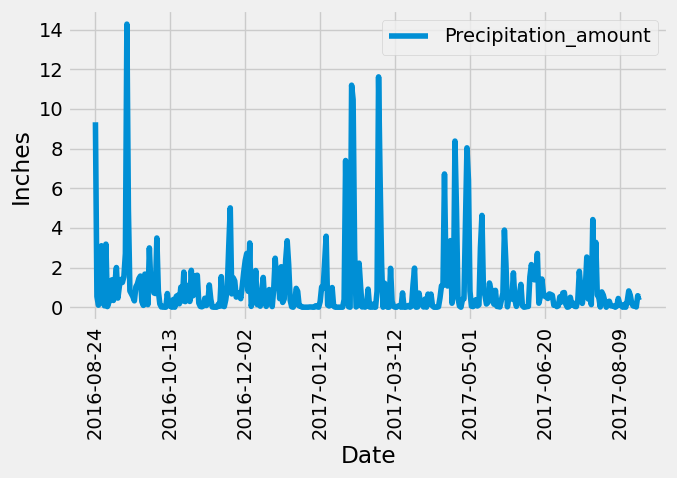

In [48]:
# Use Pandas Plotting with Matplotlib to plot the data

df = precipitation_scores.plot(xlabel='Date', ylabel = "Inches", figsize = (7,5), rot = 90)
plt.tight_layout()
plt.show()


In [49]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_scores.describe()

,Precipitation_amount
count,365.000000
mean,0.974164
std,1.776466
min,0.000000
25%,0.050000
50%,0.400000
75%,1.080000
max,14.280000


# Exploratory Station Analysis

In [54]:
# Design a query to calculate the total number of stations in the dataset
session.query(Station.id).count()

9

In [55]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
sel = [Measurement.station,func.count(Measurement.id)]
active_stations = session.query(*sel).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [56]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [func.min(Measurement.tobs),
       func.max(Measurement.tobs),
       func.avg(Measurement.tobs)]
most_active_station_id = session.query(*sel).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).first()
most_active_station_id

(54.0, 85.0, 71.66378066378067)

In [70]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
sel = [Measurement.date, 
       Measurement.tobs]
station_temps = session.query(*sel).\
        filter(func.strftime(Measurement.date) >= start_date, Measurement.station == 'USC00519281').\
        group_by(Measurement.date).\
        order_by(Measurement.date).all()

station_temps_df = pd.DataFrame(station_temps, columns=['Measurement Date', 'Temperature'])

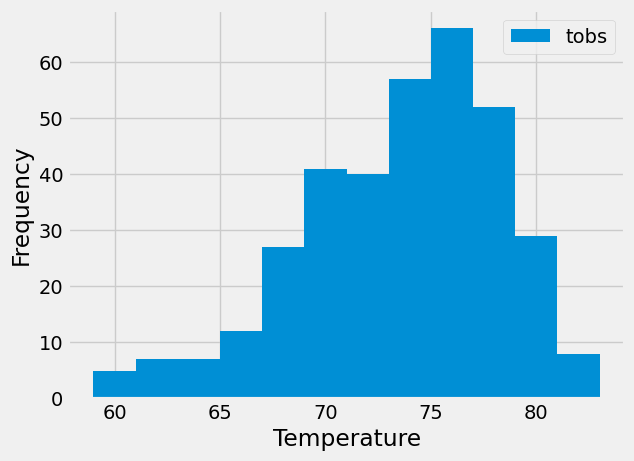

In [77]:
#creating histagarm

plt.hist(station_temps_df['Temperature'],bins=12, label="tobs", density=False)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend()
plt.figsize=(16,12)
plt.show()

# Close Session

In [78]:
# Close Session
session.close()